In [ ]:
!pip install noisereduce

In [ ]:
!git clone https://github.com/citec-spbu/classifier_of_sound_sources_it_clinic_2024.git

Cloning into 'classifier_of_sound_sources_it_clinic_2024'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 90 (delta 27), reused 55 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 33.80 MiB | 10.54 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [ ]:
from google.colab import files
import sys
sys.path.append('/preprocessing')

In [ ]:
from preprocessing.AudioPreprocessor import AudioPreprocessor

In [ ]:
!unzip "/content/yamnet_urbansound.zip" -d "/content/yamnet_urbansound"

Archive:  /content/yamnet_urbansound.zip
   creating: /content/yamnet_urbansound/yamnet_urbansound/assets/
  inflating: /content/yamnet_urbansound/yamnet_urbansound/assets/yamnet_class_map.csv  
 extracting: /content/yamnet_urbansound/yamnet_urbansound/fingerprint.pb  
  inflating: /content/yamnet_urbansound/yamnet_urbansound/keras_metadata.pb  
  inflating: /content/yamnet_urbansound/yamnet_urbansound/saved_model.pb  
   creating: /content/yamnet_urbansound/yamnet_urbansound/variables/
  inflating: /content/yamnet_urbansound/yamnet_urbansound/variables/variables.data-00000-of-00001  
  inflating: /content/yamnet_urbansound/yamnet_urbansound/variables/variables.index  


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa
import librosa.display

In [ ]:
class yamnet_model:
    def __init__(self, saved_model_path:str, classes_path:str):
        """
        * `saved_model_path` - путь до папки с файлами для инициализации дообученной модели YAMNet
        * `classes_path` - путь до pickle-файла со списком классов, на которых дообучалась модель
        """
        # self.saved_model_path = '/content/yamnet_urbansound/yamnet_urbansound1'

        # saved_model_path = '/content/yamnet_urbansound/yamnet_urbansound1'

        self.model = tf.saved_model.load(saved_model_path)

        with open('yamnet_classes.pickle', 'rb') as f:
            self.model_classes = pickle.load(f)

        self.sample_rate = 16000

    def predict(self, wav:np.ndarray, top_n:int=5):
        """
        Делает общее предсказание для входного моно wav-файла частотой 16 кГц (необходимо для работы модели)

        * `wav` - waveform в формате `np.ndarray`
        * `top_n` - какое количество наиболее вероятных классов необходимо выдать
        """

        total_results = self.model(wav)
        class_probabilities = tf.nn.softmax(total_results, axis=-1)

        top_class_indices = np.argsort(class_probabilities)[::-1][:5]

        return [self.model_classes[i] for i in top_class_indices], np.array(class_probabilities)[top_class_indices]

    def predict_with_explain(self, wav:np.ndarray, k:int=1, top_n:int=5):
        """
        Делает общее предсказание для входного моно wav-файла частотой 16 кГц (необходимо для работы модели).
        Производит предсказания для частей входного wav-файла длиной `k` секунд для определения, какие части
        оказали наибольшее влияние

        * `wav` - waveform в формате `np.ndarray`
        * `k` - длина интервала в секундах
        * `top_n` - какое количество наиболее вероятных классов необходимо выдать
        """

        # audio, sr = librosa.load(path_to_wav_file, sr=sample_rate, mono=True)

        # Шаг 2: Расчет количества сэмплов для интервала k
        segment_samples = k * self.sample_rate

        # Шаг 3: Нарезка аудио на части длиной k
        segments = [
            wav[i:i + segment_samples]
            for i in range(0, len(wav), segment_samples)
        ]

        # Делаем паддинг для последнего сегмента
        segments[-1] = np.pad(segments[-1], (0, max(0, segment_samples - len(segments[-1]))))

        # итеративно прогоняем каждый сегмент через модель
        segments_results = []
        for segment in segments:

            segment_tensor = tf.convert_to_tensor(segment, dtype=tf.float32)

            # Отправляем сегмент в модель
            result = self.model(segment_tensor)
            class_probabilities = tf.nn.softmax(result, axis=-1)
            segments_results.append(class_probabilities.numpy())


        segments_results = np.array(segments_results)

        # делаем предсказание для всего файла
        total_classes, total_probabilities = self.predict(wav, top_n=top_n)

        top_class_indices = [self.model_classes.index(class_i) for class_i in total_classes]

        top_n_segments_results = segments_results[:, top_class_indices]

        # Создаём график с указанием, наиболее влияющих участков для каждого класса

        # Создание фигуры и осей
        fig, ax = plt.subplots(figsize=(10, 6))

        # Визуализация сегментов для топ-N классов
        cax = ax.imshow(
            top_n_segments_results.T,
            aspect='auto',
            interpolation='nearest',
            cmap='gray_r'
        )

        # Настройка осей
        yticks = range(0, top_n)
        ax.set_yticks(yticks)
        ax.set_yticklabels([self.model_classes[idx] for idx in top_class_indices])
        ax.set_ylim(-0.5 + np.array([top_n, 0]))  # Настройка лимитов по y

        # Добавление цветовой шкалы
        fig.colorbar(cax, ax=ax, orientation='vertical', label='Probability')

        # Возврат объекта фигуры
        return total_classes, total_probabilities, top_n_segments_results, fig

In [ ]:
from IPython.display import Audio

wav_file_name = 'speech_whistling2.wav'

Audio(wav_file_name)

In [ ]:
ym = yamnet_model('/content/yamnet_urbansound/yamnet_urbansound', 'yamnet_classes.pickle')

In [ ]:
audio, sr = librosa.load(wav_file_name, sr=16000, mono=True)
example = AudioPreprocessor(audio, sr)

In [ ]:
example.preprocessing_auto_pipeline()

In [ ]:
example_2 = example.preprocessing_auto_pipeline()

In [ ]:
audio_2, sr_2 = example_2.return_audio()

In [ ]:
audio, sr

(array([0.        , 0.        , 0.        , ..., 0.00076294, 0.00064087,
        0.00015259], dtype=float32),
 16000)

In [ ]:
audio_2, sr_2

(array([ 2.8171005e-08,  1.4525091e-07,  1.4163642e-07, ...,
        -4.1785472e-05, -3.9333147e-05, -3.6820500e-05], dtype=float32),
 16000)

In [ ]:
ym.predict(audio_2)

(['street_music', 'drilling', 'dog_bark', 'air_conditioner', 'siren'],
 array([6.4698857e-01, 3.4187150e-01, 1.0488259e-02, 6.5145781e-04,
        1.4886072e-07], dtype=float32))

(['street_music', 'drilling', 'dog_bark', 'air_conditioner', 'siren'],
 array([6.4698857e-01, 3.4187150e-01, 1.0488259e-02, 6.5145781e-04,
        1.4886072e-07], dtype=float32),
 array([[8.2835117e-10, 1.0792905e-16, 9.9993038e-01, 6.7193694e-05,
         1.9202878e-10],
        [1.6357428e-12, 2.6974139e-01, 7.3025459e-01, 1.7780737e-11,
         2.6065203e-09],
        [9.6634299e-01, 3.3657044e-02, 3.7191100e-08, 4.4910577e-09,
         4.9694142e-12],
        [3.7757224e-09, 1.6205375e-01, 8.3794618e-01, 3.4459011e-10,
         7.3812807e-08],
        [3.0694163e-09, 9.7344029e-01, 2.6558924e-02, 8.2600769e-07,
         1.1921679e-11]], dtype=float32),
 <Figure size 1000x600 with 2 Axes>)

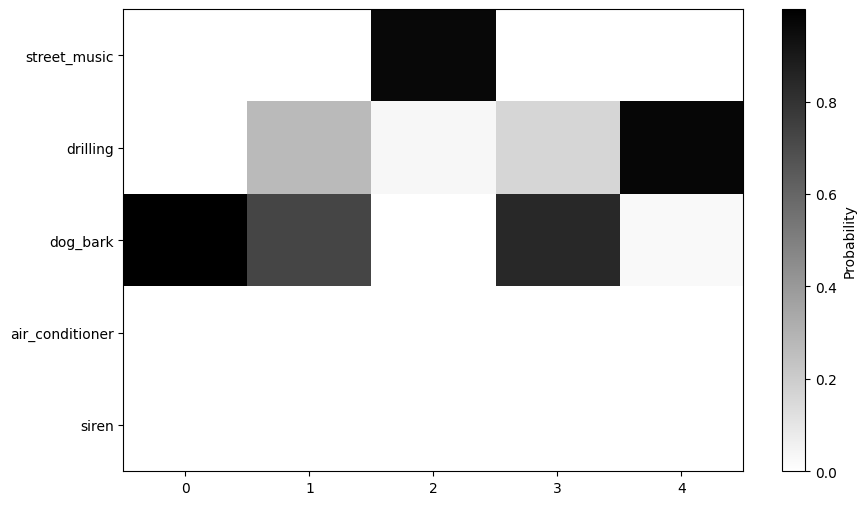

In [ ]:
ym.predict_with_explain(audio_2)